In [1]:
"""Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
Reaches 98.6% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 3s on CPU (core i7).
"""

'Trains a memory network on the bAbI dataset.\nReferences:\n- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,\n  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",\n  http://arxiv.org/abs/1502.05698\n- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,\n  "End-To-End Memory Networks",\n  http://arxiv.org/abs/1503.08895\nReaches 98.6% accuracy on task \'single_supporting_fact_10k\' after 120 epochs.\nTime per epoch: 3s on CPU (core i7).\n'

In [0]:
from __future__ import print_function

In [3]:
################################################################
# mount google drive
################################################################
import getpass
user = getpass.getuser()

if user == 'root':
    from google.colab import drive
    drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
################################################################
# import modules
################################################################
# write json files
import json

# plotting history
import matplotlib.pyplot as plt

# input, output
import os

# agrs
import sys

import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [0]:
################################################################
# parameters setting
################################################################
# fix random seeds
from numpy.random import seed
seed(3)

from tensorflow import set_random_seed
set_random_seed(31)


BATCH_SIZE=32
EPOCHS=200
VALIDATION_SPLIT=0.2
      
challenges = {
    # QA1 with 10,000 samples, single_supporting_fact_10k
    'babi-q1': 'tasks_1-20_v1-2/en-10k/qa1_' 
                                  'single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples, two_supporting_facts_10k
    'babi-q2': 'tasks_1-20_v1-2/en-10k/qa2_'
                                'two-supporting-facts_{}.txt',
}

DATA_SET = challenge_type = sys.argv[1] if len(sys.argv) > 1 and sys.argv[1] != '-f' else 'babi-q2'
challenge = challenges[challenge_type]

# check points
path_header = '/content/gdrive/My Drive/Colab Notebooks/babi-memnn/' if user == 'root' else ''
checkpoint_path = path_header + 'saved_models/' + DATA_SET + '-e{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [0]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))



In [6]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

11747328/11745123 [==============================] - 1s 0us/step


In [9]:
################################################################
# processing data
################################################################

print('Extracting stories for the challenge:', challenge_type)
with tarfile.open(path) as tar:
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


Extracting stories for the challenge: babi-q2


/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


-
Vocab size: 36 unique words
Story max length: 552 words
Query max length: 5 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'got', 'the', 'football', 'there', '.', 'John', 'went', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'garden', '.'], ['Where', 'is', 'the', 'football', '?'], 'garden')
-
Vectorizing the word sequences...
-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 552)
inputs_test shape: (1000, 552)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 5)
queries_test shape: (1000, 5)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000,)
answers_test shape: (1000,)
-
Compiling...


{10, 11, 16, 19, 22, 26}

In [0]:
################################################################
# model setups
################################################################

# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:

# save the entire models
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              verbose=0,
                                              period=1)

# train
history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=VALIDATION_SPLIT,
          callbacks = [cp_callback]
         )

Train on 8000 samples, validate on 2000 samples
Epoch 1/200
8000/8000 [==============================] - 11s 1ms/step - loss: 1.9653 - acc: 0.1623 - val_loss: 1.8111 - val_acc: 0.1810
Epoch 2/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.8321 - acc: 0.1669 - val_loss: 1.7961 - val_acc: 0.1810
Epoch 3/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.8072 - acc: 0.1705 - val_loss: 1.7921 - val_acc: 0.1835
Epoch 4/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.7971 - acc: 0.1767 - val_loss: 1.7905 - val_acc: 0.1870
Epoch 5/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.7829 - acc: 0.1971 - val_loss: 1.7584 - val_acc: 0.2340
Epoch 6/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.7552 - acc: 0.2268 - val_loss: 1.7423 - val_acc: 0.2305
Epoch 7/200
8000/8000 [==============================] - 9s 1ms/step - loss: 1.7418 - acc: 0.2397 - val_loss: 1.7259 - val_acc: 0.2490
Epoch 

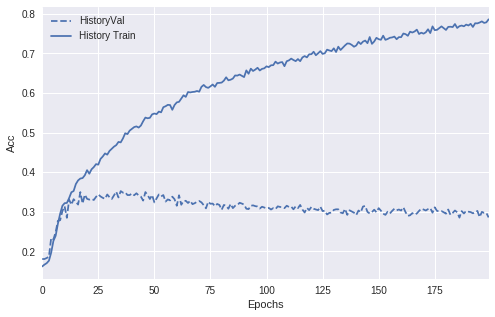

In [0]:
################################################################
# post training models
################################################################

# save history
hist_json = {}
hist_json['history'] = history.history
hist_json['epoch'] = history.epoch
hist_path = checkpoint_dir + '/'+ DATA_SET + '-history.json'

with open(hist_path, 'w') as f:
    json.dump(hist_json, f)


def plot_history(histories, key='acc'):
    plt.figure(figsize=(8, 5))

    for name, hist_i in histories:
        fig = fig1 = plt.gcf()
        val = plt.plot(hist_i['epoch'], hist_i['history']['val_' + key],
                      '--', label = name.title() + 'Val')
        plt.plot(hist_i['epoch'], hist_i['history'][key], color = val[0].get_color(),
                label = name.title() + ' Train')
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()

        plt.xlim([0,max(hist_i['epoch'])])
        #plt.show()
        plt.draw()
        fig.savefig(checkpoint_dir + '/' + DATA_SET + '-history.png', dpi=100)

with open(hist_path) as f:
    loaded_history = json.load(f)

plot_history([('history', loaded_history)])